In [1]:
import sys
import pandas as pd
import utils
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection 
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import statsmodels.formula.api as sm
from sklearn.metrics import roc_auc_score
from collections import Counter
from timeit import default_timer as timer
import pickle

In [2]:
args = sys.argv

cohort_list ='T2D_k6&T2D_k7' #'Thomas_k6&Thomas_k7'
args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list , 'kmer', 'BatchCorrected', 'bin_crc_normal', 1, 0,
        10, 'minervaclrscale',"MINERVA_grid_trans_clr_scale",1]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', 'bin_crc_normal', 1, 0,
#         10, 'raw',"raw_grid_trans_none",0]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', 'bin_crc_normal', 1, 0,
#          10, 'combat',"ComBat_grid_trans_none",0]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', 'bin_crc_normal', 1, 0,
#          10, 'limma',"limma_grid_trans_none",0]

# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc',cohort_list, 'kmer', 'BatchCorrected', 'bin_crc_normal', 1, 0,
#          10, 'bmc',"bmc_grid_trans_none",0]




In [3]:

print(args)


greater_folder = args[1] # what folder do you save your different datasets in
study_names = args[2].split("&")  # what is the name of the dataset (tells the program which folder to check)
data_type = args[3] # type of data. kmer vs OTU

prefix_name = args[4] # what is the prefix of the file name
column_of_interest = args[5] # what is the phenotype you are predicting (use the same name in the column of the metadata you want to predict), this programs reads from metadata.txt

norm_input = bool(int(args[6]))
map_with_accession = bool(int(args[7]))
num_pcs = 20
num_pcs = int(args[8])
special_name = args[9]
method = args[10]
if data_type == "otu" or data_type == "kmer":
    data_folders = [greater_folder + "/data/" + study_name + "/" for study_name in study_names] 
    metadata_folder =   greater_folder + "/data/" + study_names[0] + "/"  
else:
    data_folders = [greater_folder + "/data/" + study_name + "/" + "protect_" + column_of_interest + "/" + prefix_name + "_"  for study_name in study_names] 
    metadata_folder = greater_folder + "/data/" + study_names[0] + "/" 
PC = bool(int(args[11]))

['./run_MINERVA_test_train_grid.sh', '/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', 'T2D_k6&T2D_k7', 'kmer', 'BatchCorrected', 'bin_crc_normal', 1, 0, 10, 'minervaclrscale', 'MINERVA_grid_trans_clr_scale', 1]


In [4]:

all_datasets_dict = pickle.load(open( metadata_folder +"_" + special_name + "_MINERVA_tt_grid.pkl", "rb" ))
            

In [5]:
all_datasets_dict

{'dataset0': {'number samples': [256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256,
   256],
  'PC0': {'train_best_params': {0: {'criterion': 'entropy',
     'max_depth': 1,
     'max_features': 0.5,
     'min_samples_leaf': 5,
     'min_samples_split': 5,
     'n_estimators': 1000},
    1: {'criterion': 'entropy',
     'max_depth': 1,
     'max_features': 0.3,
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 100},
    2: {'criterion': 'entropy',
     'max_depth': 1,
     'max_features': 0.3,
     'min_samples_leaf': 10,
     'min_samples_split': 5,
     'n_estimators': 100},
    3: {'criterion': 'entropy',
     'max_depth': 

In [6]:
import matplotlib.pyplot as plt

# check MINERVA PCs


train_auc = []
test_auc = []
dataset_num = 1
for i in range(10):
      
    if not PC:
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]['train_auc_trained'])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]['test_auc_trained'])
    else:   
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)]['train_auc_trained'])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)]['test_auc_trained'])
    
x = np.array(train_auc)
y = np.array(test_auc)
plt.scatter( x,  y)

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title(study_names[dataset_num] + " MINERVA")
plt.show()

<Figure size 640x480 with 1 Axes>

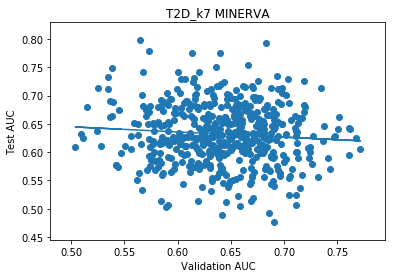

In [7]:
# check MINERVA PCs
dataset_num = 1

train_auc = []
test_auc = []
for i in range(10):
    if not PC:
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]['val_auc_trained'])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]['test_auc_trained'])
    else:   
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)]['val_auc_trained'])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)]['test_auc_trained'])
    
x = np.array(train_auc)
y = np.array(test_auc)
plt.scatter( x,  y)

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

plt.xlabel("Validation AUC")
plt.ylabel("Test AUC")
plt.title(study_names[dataset_num] +" MINERVA")
plt.show()

In [8]:
PC

True

0


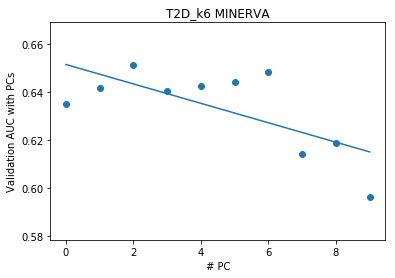

1


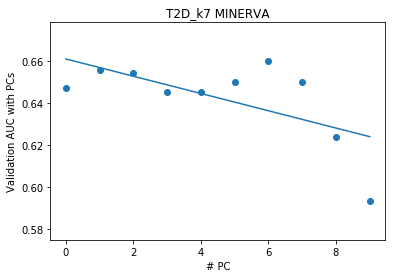

In [9]:
#check overall correlation or trend

auc_collection = dict()
pc_number_collection = dict()


for dataset_num in [0,1]:
    print(dataset_num)
    auc_val = []
    pc_num = []
    auc = []
    plot_train = False
    plot_validation = True
    
    if not PC:
        auc_val.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]['val_auc_trained']))
    else:

        if plot_train:
            ylab_input = "Train AUC with PCs"
        else:
            if plot_validation:
                ylab_input = "Validation AUC with PCs"
            else:
                ylab_input = "Test AUC with PCs"
        for i in range(10):
            pc_num.append(i)
            auc_val.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)]['val_auc_trained']))
            if plot_train:
                auc.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)]['train_auc_trained']))
            else:
                if plot_validation:
                    auc.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)]['val_auc_trained']))
                else:
                    auc.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)]['test_auc_trained']))

        x = np.array(pc_num)
        y = np.array(auc)
        plt.scatter( x,  y)

        m, b = np.polyfit(x, y, 1)

        plt.plot(x, m*x + b)

        plt.xlabel("# PC")
        plt.ylabel(ylab_input)
        plt.title(study_names[dataset_num] + " MINERVA")
        plt.show()
        #auc_collection.append(auc)
    
    
    auc_collection["dataset" + str(dataset_num)] = auc_val
    if PC:
        pc_number_collection["dataset" + str(dataset_num)] = pc_num
    

# plt.plot(x1, y1, "g")



# plt.plot(x2, y2, "r")

In [10]:
auc_collection


{'dataset0': [0.6350194528211099,
  0.6418704308406487,
  0.651083859232167,
  0.6402933020548415,
  0.6426921884295815,
  0.6440216885552017,
  0.6483097108212887,
  0.6142147915371208,
  0.6189219568546639,
  0.5964905183222731],
 'dataset1': [0.6470846222983293,
  0.655411071624163,
  0.6543385625073546,
  0.644946655011094,
  0.6450006785254213,
  0.6499668545535972,
  0.6597703309873972,
  0.6501197091361786,
  0.6236780790637677,
  0.593296818225887]}

In [11]:
if PC:
    
    best_pc_per_dataset = []
    best_auc_per_dataset = []

    for dataset_num in [0,1]:


        index_best_pc = auc_collection["dataset" + str(dataset_num)].index(max(auc_collection["dataset" + str(dataset_num)]))
        best_auc_per_dataset.append(auc_collection["dataset" + str(dataset_num)][index_best_pc])
        best_pc_per_dataset.append(index_best_pc)
else:
    best_auc_per_dataset = []
    for dataset_num in [0,1]:
        best_auc_per_dataset.append(auc_collection["dataset" + str(dataset_num)])

In [12]:
if PC:
    best_kmer = best_auc_per_dataset.index(max(best_auc_per_dataset))
    best_pc = best_pc_per_dataset[best_kmer]
else:
    best_kmer = best_auc_per_dataset.index(max(best_auc_per_dataset))



In [13]:
# best_kmer

In [14]:
output_dict = dict()

output_dict[method]=dict()
output_dict[method]['Random Forest'] = dict()
print("best_kmer" + str(study_names[best_kmer]))
if PC:
    all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)]['test_auc_trained']
    output_dict[method]['Random Forest']['auc_all'] = all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)]['test_auc_trained']
else:
    output_dict[method]['Random Forest']['auc_all'] = all_datasets_dict['dataset' + str(best_kmer)]['test_auc_trained']
    
    
pickle.dump(output_dict , open( data_folders[best_kmer] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + method + "_classification_auc.pkl", "wb" ) )
       

best_kmerT2D_k7


In [15]:
output_dict 

{'MINERVA_grid_trans_clr_scale': {'Random Forest': {'auc_all': [0.6602079395085065,
    0.6020793950850661,
    0.5964083175803403,
    0.5719806763285025,
    0.7260869565217392,
    0.6625708884688091,
    0.6493383742911153,
    0.6285444234404537,
    0.6565217391304348,
    0.6072463768115942,
    0.7348771266540642,
    0.6975425330812854,
    0.6290170132325142,
    0.5768115942028985,
    0.6357487922705314,
    0.6810018903591682,
    0.5959357277882797,
    0.6332703213610587,
    0.6367149758454106,
    0.6932367149758454,
    0.6318525519848771,
    0.7934782608695652,
    0.6186200378071833,
    0.6130434782608696,
    0.5821256038647343,
    0.6880907372400756,
    0.642249527410208,
    0.6205103969754253,
    0.5560386473429951,
    0.6135265700483091,
    0.7046313799621928,
    0.6568998109640831,
    0.6318525519848772,
    0.6144927536231883,
    0.7256038647342995,
    0.6455576559546314,
    0.6016068052930056,
    0.5685255198487712,
    0.7014492753623188,
    0